<a href="https://colab.research.google.com/github/fjadidi2001/DataScienceJourney/blob/master/PINNs_S4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train the model using NN methods

## Step 1: Import Necessary Libraries


In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


## Step 2: Load and Prepare the Dataset


In [6]:
# Load the dataset
california_housing = fetch_california_housing(as_frame=True)


In [7]:
print(california_housing.DESCR)


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [8]:
california_housing.frame.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [9]:
california_housing.data.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [10]:
california_housing.target.head()


,MedHouseVal
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


In [11]:
california_housing.frame.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


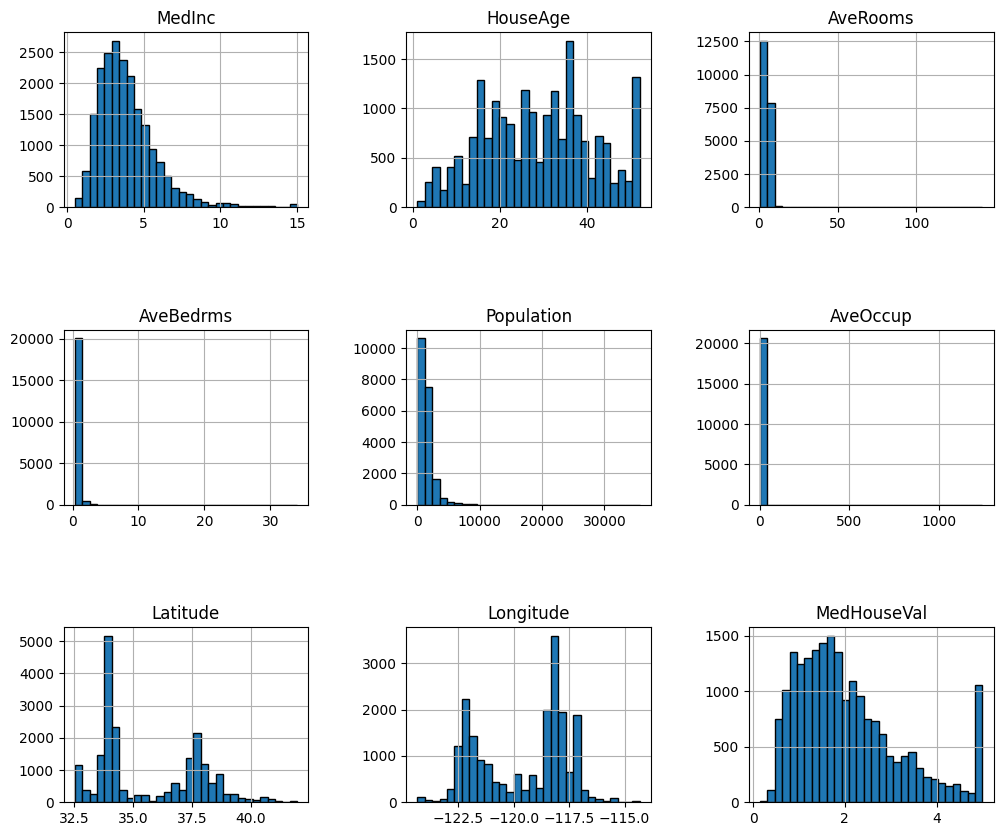

In [12]:
import matplotlib.pyplot as plt

california_housing.frame.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [13]:
features_of_interest = ["AveRooms", "AveBedrms", "AveOccup", "Population"]
california_housing.frame[features_of_interest].describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000
mean,5.429000,1.096675,3.070655,1425.476744
std,2.474173,0.473911,10.386050,1132.462122
min,0.846154,0.333333,0.692308,3.000000
25%,4.440716,1.006079,2.429741,787.000000
50%,5.229129,1.048780,2.818116,1166.000000
75%,6.052381,1.099526,3.282261,1725.000000
max,141.909091,34.066667,1243.333333,35682.000000


In [14]:

# Convert to DataFrame for better visualization
df = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
df['Target'] = california_housing.target

# Display the first few rows of the dataset
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


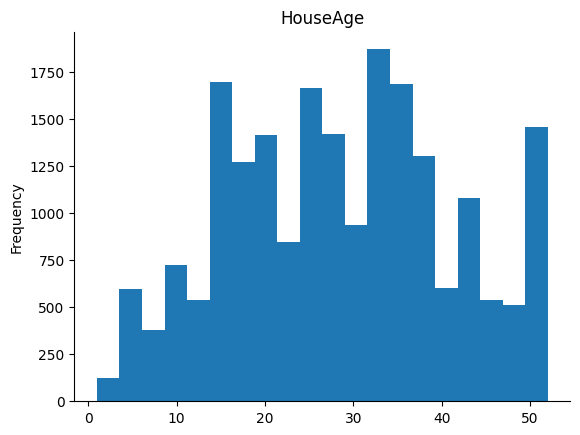

In [ ]:
# @title HouseAge

from matplotlib import pyplot as plt
df['HouseAge'].plot(kind='hist', bins=20, title='HouseAge')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Step 3: Split the Data into Features and Target


In [ ]:
# Split the data into features (X) and target (y)
X = df.drop('Target', axis=1)
y = df['Target']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Step 4: Scale the Features


In [ ]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Step 5: Create and Compile the Model


In [ ]:
# Create the model
model = models.Sequential()

# Add layers
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,801 (18.75 KB)

 Trainable params: 4,801 (18.75 KB)

 Non-trainable params: 0 (0.00 B)

## Step 6: Train the Model


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)


Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 186.0295 - mae: 5.9350 - val_loss: 1.1235 - val_mae: 0.8085
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4192 - mae: 0.8967 - val_loss: 1.4410 - val_mae: 1.0228
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.5823 - mae: 0.8757 - val_loss: 304.2381 - val_mae: 14.6544
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 49.8039 - mae: 3.8392 - val_loss: 1.0459 - val_mae: 0.8242
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.3670 - mae: 1.1110 - val_loss: 12.1808 - val_mae: 2.6942
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 39.9122 - mae: 3.1880 - val_loss: 1.4928 - val_mae: 0.9825
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4654 - mae: 0.8492 - val_loss: 1.2882 - val_mae: 0.9060
Epoch 8/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17.7572 - mae: 1.9040 - val_loss: 0.7290 - val_mae: 0.6488
Epoch 9/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

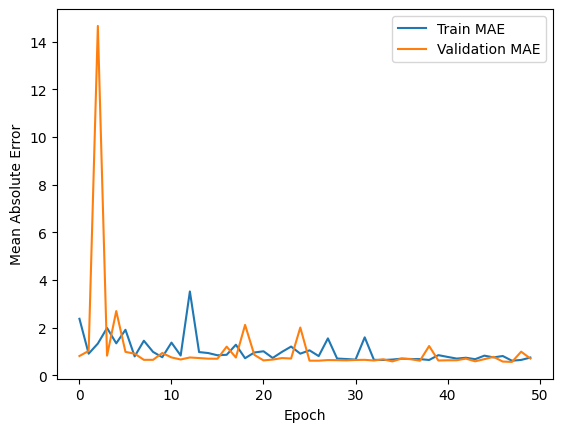

In [ ]:
# Plot training history
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()



- **Data Preparation:** We loaded the California Housing dataset, split it into training and test sets, and scaled the features.
- **Model Creation:** We built a simple feedforward neural network with two hidden layers.
- **Training:** We trained the model for 50 epochs and monitored its performance using validation data.
- **Evaluation:** We evaluated the model on the test set and visualized the results to understand its performance.



## Step 7: Evaluate the Model


In [ ]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6996 - mae: 0.6984
Test MAE: 0.7011523842811584


## Step 8: Make Predictions


In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
print(y_pred)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[1.1569897]
 [1.9981943]
 [3.1375022]
 ...
 [4.579888 ]
 [2.094378 ]
 [2.1077695]]


# Train the California Housing dataset with a basic PINN structure

## Step 1: Import Necessary Libraries


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K


## Step 2: Load and Prepare the Dataset


In [ ]:
# Load the dataset
california = fetch_california_housing()

# Convert to DataFrame for better visualization
df = pd.DataFrame(california.data, columns=california.feature_names)
df['Target'] = california.target

# Display the first few rows of the dataset
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Step 3: Split the Data into Features and Target


In [ ]:
# Split the data into features (X) and target (y)
X = df.drop('Target', axis=1)
y = df['Target']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Step 4: Scale the Features


In [ ]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Step 5: Define the PINN Model


In [ ]:
# Define the PINN model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer_1 = layers.Dense(64, activation='relu')
        self.hidden_layer_2 = layers.Dense(64, activation='relu')
        self.output_layer = layers.Dense(1)

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        return self.output_layer(x)

    def train_step(self, data):
        X, y = data

        with tf.GradientTape() as tape:
            y_pred = self(X, training=True)
            loss = self.compiled_loss(y, y_pred)

            # Implement the PINN constraint (Example: derivative constraint)
            with tf.GradientTape() as tape2:
                tape2.watch(X)
                y_pred = self(X, training=True)
            gradients = tape2.gradient(y_pred, X)
            constraint_loss = K.mean(tf.square(gradients[:, 0] - 1.0))  # Example constraint

            total_loss = loss + constraint_loss

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

# Instantiate the model
pinn_model = PINN()

# Compile the model with a custom training step
pinn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])


## Step 6: Train the PINN Model


In [ ]:
# Train the PINN model
history = pinn_model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:607: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:582: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - mae: 0.7957 - loss: 1.6932 - val_loss: 0.4690 - val_mae: 0.4901
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - mae: 0.4697 - loss: 2.0376 - val_loss: 0.4316 - val_mae: 0.4627
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - mae: 0.4381 - loss: 2.0556 - val_loss: 0.4113 - val_mae: 0.4490
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - mae: 0.4409 - loss: 2.0550 - val_loss: 0.4013 - val_mae: 0.4486
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - mae: 0.4322 - loss: 2.0619 - val_loss: 0.4220 - val_mae: 0.4502
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - mae: 0.4217 - loss: 2.0656 - val_loss: 0.3925 - val_mae: 0.4374
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - mae: 0.4219 - loss: 2.0585 - val_loss: 0.4003 - val_mae: 0.4320
Epoch 8/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - mae: 0.4173 - loss: 2.0474 - val_loss: 0.3817 - val_mae: 0.4294
Epoch 9/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - mae: 0.4173 -

## Step 7: Plot Training History


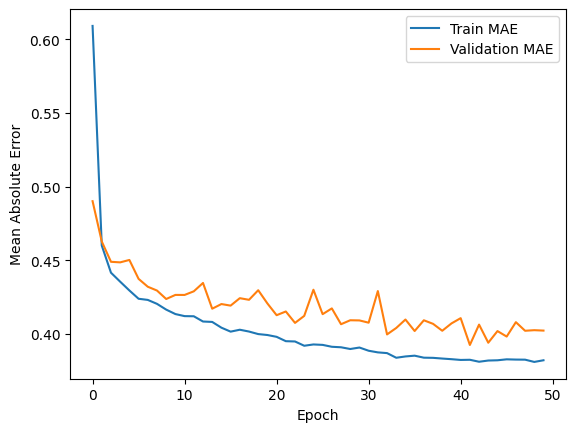

In [ ]:
# Plot training history
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


## Step 8: Evaluate the PINN Model


In [ ]:
# Evaluate the model on the test set
test_loss, test_mae = pinn_model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3151 - mae: 0.3906
Test MAE: 0.3958660364151001


## Step 9: Make Predictions


In [ ]:
# Make predictions on the test set
y_pred = pinn_model.predict(X_test)
print(y_pred)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[0.6765418]
 [1.4998381]
 [4.589984 ]
 ...
 [4.828855 ]
 [0.6701598]
 [1.7663598]]


# Implement Physics-Informed Multi-Task Learning with TensorFlow on the California Housing dataset

## Step 1: Import Necessary Libraries


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K


## Step 2: Load and Prepare the Dataset


In [ ]:
# Load the dataset
california = fetch_california_housing()

# Convert to DataFrame for better visualization
df = pd.DataFrame(california.data, columns=california.feature_names)
df['Target'] = california.target

# Split the data into features (X) and target (y)
X = df.drop('Target', axis=1)
y = df['Target']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Step 3: Define the Physics-Informed Multi-Task Model


In [ ]:
class PIMTL(tf.keras.Model):
    def __init__(self):
        super(PIMTL, self).__init__()
        # Shared layers for both tasks
        self.shared_layer_1 = layers.Dense(64, activation='relu')
        self.shared_layer_2 = layers.Dense(64, activation='relu')

        # Output for predicting house prices (Task 1)
        self.price_output = layers.Dense(1, name="price_output")

        # Output for physics-informed constraint (Task 2)
        self.physics_output = layers.Dense(1, name="physics_output")

    def call(self, inputs):
        # Forward pass through shared layers
        x = self.shared_layer_1(inputs)
        x = self.shared_layer_2(x)

        # Task 1: Predict house prices
        price_pred = self.price_output(x)

        # Task 2: Output for physics-informed constraint
        physics_pred = self.physics_output(x)

        return price_pred, physics_pred

    def train_step(self, data):
        X, y = data
        y_true, physics_target = y

        with tf.GradientTape() as tape:
            y_pred, physics_pred = self(X, training=True)

            # Loss for price prediction (Task 1)
            price_loss = self.compiled_loss(y_true, y_pred)

            # Loss for physics-informed task (Task 2)
            physics_loss = self.compiled_loss(physics_target, physics_pred)

            # Combine losses (weighted sum)
            total_loss = price_loss + physics_loss

        # Compute gradients and update weights
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics
        self.compiled_metrics.update_state(y_true, y_pred)
        return {m.name: m.result() for m in self.metrics}


## Step 4: Define Physics Constraints


In [ ]:
def physics_constraint(X):
    """
    Define a simple physics-based relationship for task 2.
    We assume that house prices (Target) should increase with both
    median income (MedInc) and average rooms per household (AveRooms).
    """
    # Get MedInc and AveRooms from the features
    MedInc = X[:, 0]
    AveRooms = X[:, 2]

    # Construct a pseudo-target where we enforce that the price should
    # increase with MedInc and AveRooms
    pseudo_target = MedInc * AveRooms / 10  # Scaling down for simplicity

    return pseudo_target


## Step 5: Compile and Train the Model with Named Outputs


In [ ]:
# Prepare the physics target for Task 2
physics_target_train = physics_constraint(X_train)
physics_target_test = physics_constraint(X_test)

# Compile the model
pimtl_model = PIMTL()
pimtl_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = pimtl_model.fit(
    X_train,
    [y_train, physics_target_train],  # Two targets: price and physics constraint
    epochs=50,
    validation_data=(X_test, [y_test, physics_target_test]),
    batch_size=32
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:607: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:582: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - mae: 0.8143 - loss: 1.7136 - val_loss: 0.4164 - val_mae: 0.4631
Epoch 2/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - mae: 0.4482 - loss: 2.0713 - val_loss: 0.3855 - val_mae: 0.4288
Epoch 3/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - mae: 0.4352 - loss: 2.0684 - val_loss: 0.3578 - val_mae: 0.4202
Epoch 4/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - mae: 0.4143 - loss: 2.0621 - val_loss: 0.3484 - val_mae: 0.4193
Epoch 5/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - mae: 0.4110 - loss: 2.0686 - val_loss: 0.3407 - val_mae: 0.4029
Epoch 6/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - mae: 0.3998 - loss: 2.0656 - val_loss: 0.3244 - val_mae: 0.3929
Epoch 7/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - mae: 0.4015 - loss: 2.0786 - val_loss: 0.3172 - val_mae: 0.3891
Epoch 8/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - mae: 0.3833 - loss: 2.0620 - val_loss: 0.3418 - val_mae: 0.4210
Epoch 9/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - mae: 0.3899 -

## Step 6: Plot Training History


In [ ]:
# Print the available keys in the history to check the metric names
print(history.history.keys())


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


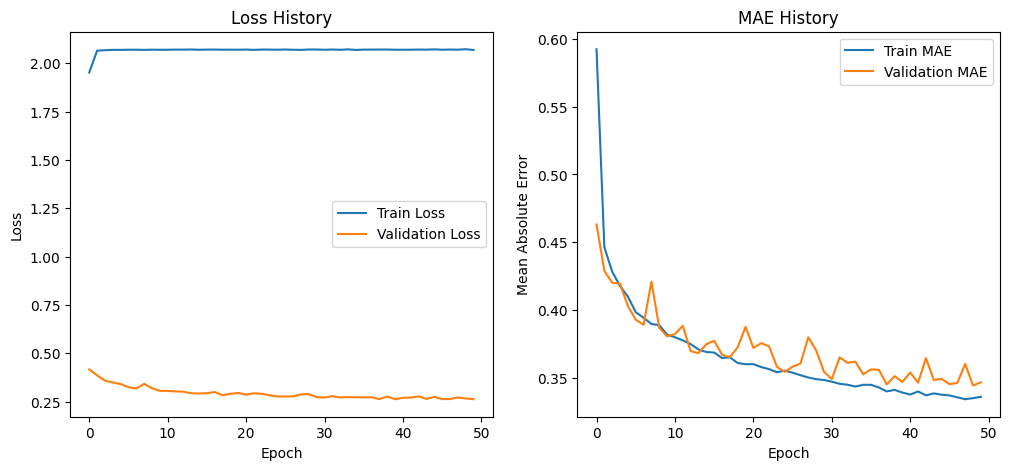

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('MAE History')

plt.show()


## Step 7: Evaluate the Model


In [ ]:
# Evaluate the model on test data
test_loss, test_mae = pimtl_model.evaluate(X_test, [y_test, physics_target_test])

print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2539 - mae: 0.3426
Test Loss: 0.2620503604412079
Test MAE: 0.34663113951683044


# Implementing Physics-Informed Kolmogorov-Arnold Networks (PIKAR)

## Step 1: Load and Preprocess the California Housing Dataset


In [ ]:
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the California Housing dataset
data = fetch_california_housing()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert targets to float32 for TensorFlow compatibility
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)


## Step 2: Build a PIKAN-Inspired Neural Network


In [ ]:
from tensorflow.keras import layers, models

# Define the PIKAN-inspired network structure
def create_pikan_model(input_shape):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Subnet 1
    x1 = layers.Dense(64, activation='relu')(inputs)
    x1 = layers.Dense(32, activation='relu')(x1)
    x1 = layers.Dense(1)(x1)

    # Subnet 2
    x2 = layers.Dense(64, activation='relu')(inputs)
    x2 = layers.Dense(32, activation='relu')(x2)
    x2 = layers.Dense(1)(x2)

    # Subnet 3
    x3 = layers.Dense(64, activation='relu')(inputs)
    x3 = layers.Dense(32, activation='relu')(x3)
    x3 = layers.Dense(1)(x3)

    # Combine the subnets using a sum operation
    combined = layers.Add()([x1, x2, x3])

    # Output layer
    outputs = layers.Dense(1)(combined)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the model
input_shape = X_train.shape[1:]
pikan_model = create_pikan_model(input_shape)

# Compile the model
pikan_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display the model architecture
pikan_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 8)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │            576 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │            576 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │            576 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │          2,080 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 32)             │          2,080 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             33 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │             33 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 1)              │             33 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1)              │              0 │ dense_2[0][0],         │
│                           │                        │                │ dense_5[0][0],         │
│                           │                        │                │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1)              │              2 │ add[0][0]              │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,069 (31.52 KB)

 Trainable params: 8,069 (31.52 KB)

 Non-trainable params: 0 (0.00 B)

## Step 3: Train the Network


In [ ]:
# Train the model
history = pikan_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)


Epoch 1/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.8737 - mae: 0.6366 - val_loss: 0.8829 - val_mae: 0.4807
Epoch 2/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4007 - mae: 0.4400 - val_loss: 0.3850 - val_mae: 0.4224
Epoch 3/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3892 - mae: 0.4223 - val_loss: 0.3652 - val_mae: 0.4343
Epoch 4/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3290 - mae: 0.4014 - val_loss: 0.3365 - val_mae: 0.4057
Epoch 5/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3216 - mae: 0.3969 - val_loss: 0.3192 - val_mae: 0.3857
Epoch 6/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3071 - mae: 0.3874 - val_loss: 0.3124 - val_mae: 0.3960
Epoch 7/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3214 - mae: 0.3950 - val_loss: 0.3215 - val_mae: 0.4070
Epoch 8/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3204 - mae: 0.3798 - val_loss: 0.3107 - val_mae: 0.3869
Epoch 9/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - l

## Step 4: Evaluate and Visualize the Results


129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2700 - mae: 0.3460
Test Loss: 0.2761
Test MAE: 0.3453


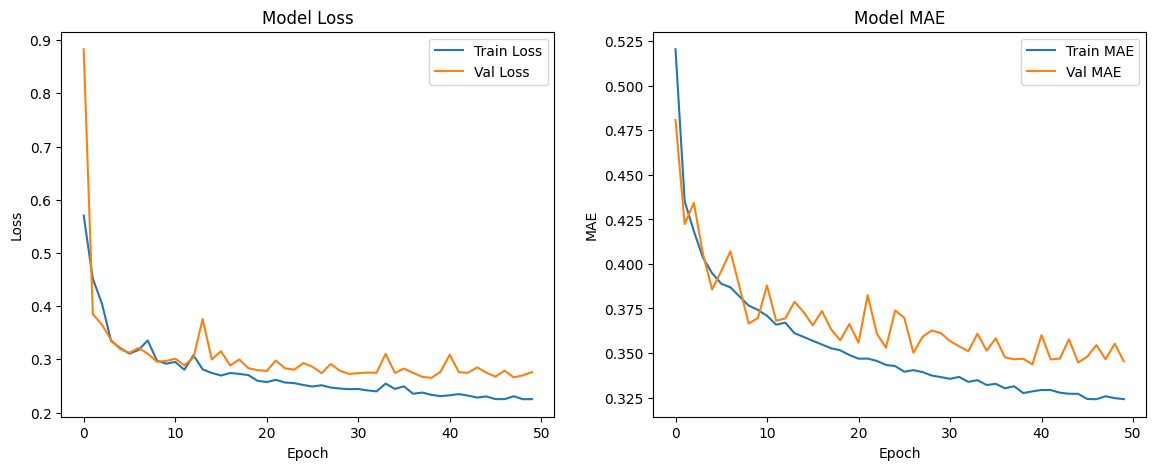

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_mae = pikan_model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Plot training & validation loss values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()
